# CSV File Ingestion Step by Step

In [8]:
# Perform required imports
import pandas as pd
import psycopg2
import logging
from sqlalchemy import create_engine, Date, SmallInteger

In [9]:
# Load and display the first few rows of the 'candidates.csv' dataset.
candidates = pd.read_csv('candidates.csv',sep=';')
candidates.head()

,First Name,Last Name,Email,Application Date,Country,YOE,Seniority,Technology,Code Challenge Score,Technical Interview Score
0,Bernadette,Langworth,leonard91@yahoo.com,2021-02-26,Norway,2,Intern,Data Engineer,3,3
1,Camryn,Reynolds,zelda56@hotmail.com,2021-09-09,Panama,10,Intern,Data Engineer,2,10
2,Larue,Spinka,okey_schultz41@gmail.com,2020-04-14,Belarus,4,Mid-Level,Client Success,10,9
3,Arch,Spinka,elvera_kulas@yahoo.com,2020-10-01,Eritrea,25,Trainee,QA Manual,7,1
4,Larue,Altenwerth,minnie.gislason@gmail.com,2020-05-20,Myanmar,13,Mid-Level,Social Media Community Management,9,7


In [10]:
# Display summary information about the 'candidates' dataset.
candidates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   First Name                 50000 non-null  object
 1   Last Name                  50000 non-null  object
 2   Email                      50000 non-null  object
 3   Application Date           50000 non-null  object
 4   Country                    50000 non-null  object
 5   YOE                        50000 non-null  int64 
 6   Seniority                  50000 non-null  object
 7   Technology                 50000 non-null  object
 8   Code Challenge Score       50000 non-null  int64 
 9   Technical Interview Score  50000 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 3.8+ MB


In [11]:
# Summarize 'hired_candidates' dataset after filtering by scores.
hired_candidates = candidates[(candidates['Code Challenge Score']>=7) & (candidates['Technical Interview Score']>=7)]
hired_candidates.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6698 entries, 2 to 49990
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   First Name                 6698 non-null   object
 1   Last Name                  6698 non-null   object
 2   Email                      6698 non-null   object
 3   Application Date           6698 non-null   object
 4   Country                    6698 non-null   object
 5   YOE                        6698 non-null   int64 
 6   Seniority                  6698 non-null   object
 7   Technology                 6698 non-null   object
 8   Code Challenge Score       6698 non-null   int64 
 9   Technical Interview Score  6698 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 575.6+ KB


In [12]:
# Establish a database connection using the provided parameters.
def connect_to_database():
    db_conn = {
        'user': 'postgres',
        'password': 'postgres',
        'database': 'postgres',
        'host': 'localhost',
        'port': 15432
    }
    try:
        conn = psycopg2.connect(**db_conn)
        return conn
    except Exception as e:
        logging.error("Error: Unable to connect to the database")
        logging.error(e)
        return None

In [13]:
# Establish a connection to the database and load 'hired_candidates' and 'candidates' datasets into it with specified data types.
conn = connect_to_database()

engine = create_engine('postgresql+psycopg2://',creator=lambda: conn)

data_types = {
    'Application Date': Date,
    'YOE': SmallInteger,
    'Code Challenge Score': SmallInteger,
    'Technical Interview Score': SmallInteger
}

hired_candidates.to_sql(
    name='hired_candidates',
    con=engine,
    index=False,
    if_exists='replace',
    dtype=data_types
)

candidates.to_sql(
    name='candidates',
    con=engine,
    index=False,
    if_exists='replace',
    dtype=data_types
)

1000

# Visualizations

In [14]:
# Perform required imports
import matplotlib.pyplot as plt

In [15]:
# Establish a new connection to the database
conn = connect_to_database()

engine = create_engine('postgresql+psycopg2://',creator=lambda: conn)

In [16]:
# Hires by technology (pie chart)
hires_by_tech = pd.read_sql_query('SELECT "Technology" AS tech, COUNT(*) AS count FROM hired_candidates GROUP BY tech',engine)
hires_by_tech.head()

,tech,count
0,DevOps,495
1,Client Success,271
2,Security,266
3,Technical Writing,223
4,Business Analytics / Project Management,255


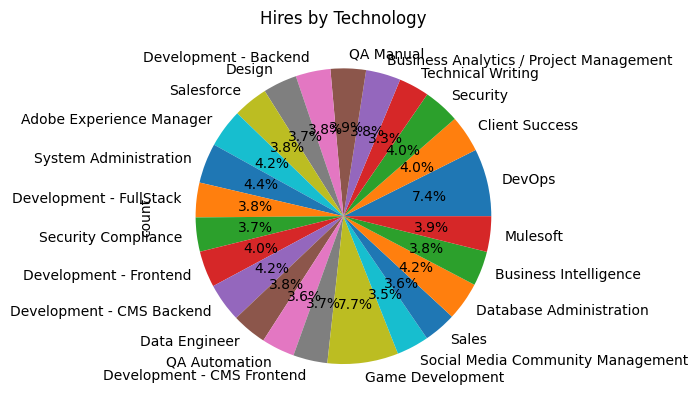

In [17]:
hires_by_tech.plot(kind='pie',y='count',legend=False,labels=hires_by_tech['tech'],autopct='%1.1f%%',title='Hires by Technology')
plt.show()

In [18]:
# Hires by year (horizontal bar chart)
hires_by_year = pd.read_sql_query("""SELECT EXTRACT(YEAR FROM "Application Date") as year, 
                                  COUNT(*) AS count 
                                  FROM hired_candidates 
                                  GROUP BY year
                                  ORDER BY year DESC""",engine)
hires_by_year.head()

,year,count
0,2022.0,795
1,2021.0,1485
2,2020.0,1485
3,2019.0,1524
4,2018.0,1409


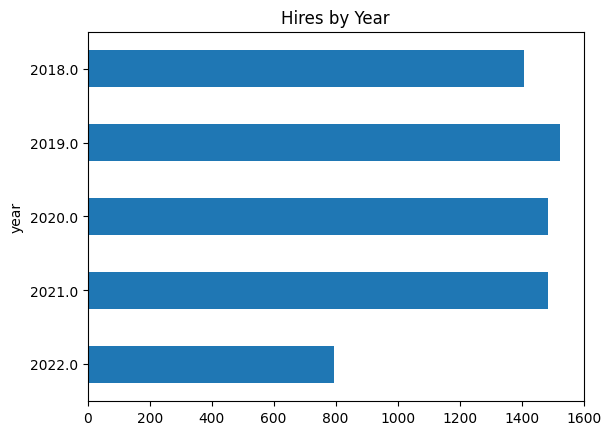

In [19]:
hires_by_year.plot(kind='barh',y='count',x='year',legend=False,title='Hires by Year')
plt.show()

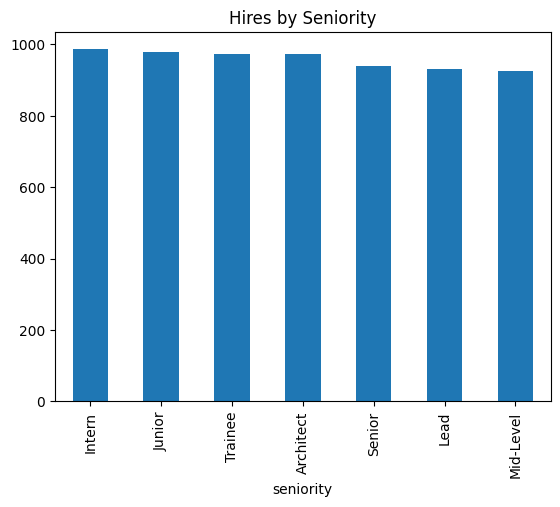

In [20]:
# Hires by seniority (bar chart)
hires_by_seniority = pd.read_sql_query("""SELECT "Seniority" as seniority, 
                                  COUNT(*) AS count 
                                  FROM hired_candidates 
                                  GROUP BY seniority
                                  ORDER BY count DESC""",engine)
hires_by_seniority.plot(kind='bar',y='count',x='seniority',legend=False,title='Hires by Seniority')
plt.show()

In [21]:
# Hires by country over years (USA, Brazil, Colombia, and Ecuador only)(multiline chart)
hires_by_country = pd.read_sql_query("""SELECT EXTRACT(YEAR FROM "Application Date") as year, 
                                        "Country" as country,
                                        COUNT(*) AS count 
                                        FROM hired_candidates 
                                        WHERE "Country" IN ('United States of America','Brazil','Colombia','Ecuador')
                                        GROUP BY year, country""",engine)
hires_by_country.head()

,year,country,count
0,2019.0,Ecuador,3
1,2020.0,Brazil,6
2,2018.0,Brazil,9
3,2020.0,Ecuador,8
4,2022.0,Colombia,1


In [22]:
# Pivot 'hires_by_country' data to show hires by country over years.
pivoted_hires_by_country = hires_by_country.pivot(index='year',columns='country',values='count')
pivoted_hires_by_country.head()

country,Brazil,Colombia,Ecuador,United States of America
year,,,,
2018.0,9,7,1,5
2019.0,7,8,3,3
2020.0,6,8,8,4
2021.0,7,1,5,8
2022.0,4,1,3,5


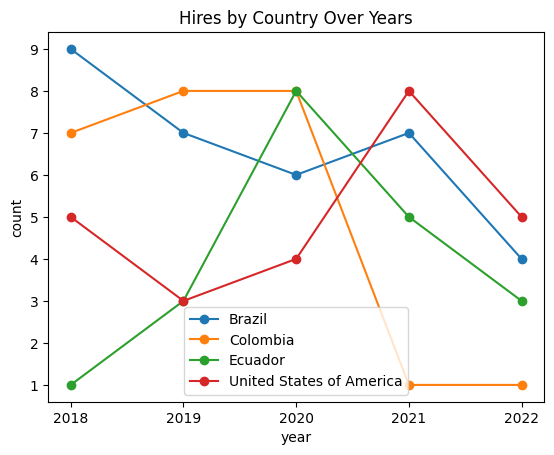

In [23]:
# Visualize hires by country over the years.
for country in pivoted_hires_by_country.columns:
    plt.plot(pivoted_hires_by_country.index, pivoted_hires_by_country[country],label=country,marker='o')

plt.xticks(pivoted_hires_by_country.index.astype(int))
plt.xlabel('year')
plt.ylabel('count')
plt.legend()
plt.title('Hires by Country Over Years')
plt.show()